In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
import numpy as np


def scheduler(T, s=0.008):
    f_t = lambda t: np.cos(((t/T + s) / (1 + s)) * (np.pi / 2)) ** 2
    alpha_bar_t = [1]
    beta = []
    for t in range(1, T+1):
        alpha_bar_t.append(f_t(t) / f_t(0))
        beta.append(np.clip(1 - (f_t(t) / f_t(t-1)), 0, 0.999))
    alpha_t = 1 - np.array(beta)

    return np.array(alpha_bar_t), alpha_t, np.array(beta)

# print(scheduler(10))

In [4]:
T = 1000
alpha_bar, _, _ = scheduler(T)

In [6]:
alpha_bar

array([1.00000000e+00, 9.99958716e-01, 9.99912576e-01, ...,
       9.71504404e-06, 2.42876691e-06, 3.74998224e-33])

In [7]:
T = 1000
alpha_bar, _, _ = scheduler(T)

In [9]:
x = np.random.randint(1, T+1, size=32)
print(x)
print(alpha_bar[x])

[380 933 915 814 486 739 252 558 832 331 340 468 258 418 673 823 442  15
 927 119 813 976 948 448 710 383 245 933 913 805 798 886]
[0.67695924 0.01086318 0.01744547 0.08169882 0.51566091 0.15652586
 0.84476045 0.40404649 0.06699771 0.74605642 0.73374835 0.54366236
 0.83792532 0.62045246 0.23799094 0.07418073 0.58384385 0.99887116
 0.01288717 0.9614906  0.08255459 0.00139832 0.00655303 0.57461043
 0.19072748 0.67257811 0.85258227 0.01086318 0.018271   0.08954606
 0.0958731  0.03123362]


In [18]:
def create_noisy_image(x: torch.Tensor, T: int, alpha_bar: np.array):
    steps = np.random.randint(1, T+1, size=x.size(0)) # generate random number ==> step
    alpha_bar_step = alpha_bar[steps]
    alpha_bar_t = torch.from_numpy(alpha_bar_step).reshape(-1, 1, 1, 1)
    noise = torch.randn_like(x)
    out = (alpha_bar_t ** 0.5) * x + ((1 - alpha_bar_t) ** 0.5) * noise
    return out, torch.from_numpy(steps), noise

In [13]:
# a = [3, 4, 5, 6]
# f(*a) ===> f(3, 4, 5, 6)
a, b = zip((2, 3), (4, 5), (6, 7))
a

(2, 4, 6)

In [14]:
def noisy_image_collate(x):
    # x ==> [(data1, label1), (data2, label2), ..., (data32, label32)]
    tensors, targets = zip(*x)
    tensors = [img.unsqueeze(0) for img in tensors]
    x_noisy, steps, noise = create_noisy_image(torch.cat(tensors, 0), T, alpha_bar)
    return [x_noisy, steps, noise]

In [ ]:
batch_size = 32

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True,
                                      transform=ToTensor())

original_dloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_dloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=noisy_image_collate)

In [23]:
next(iter(train_dloader))[2].size()

torch.Size([32, 1, 28, 28])

In [16]:
import matplotlib.pyplot as plt

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Original images


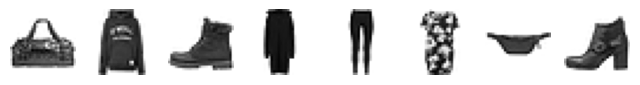

steps: [230 771 238  32 723 638  76 967]
Noisy images


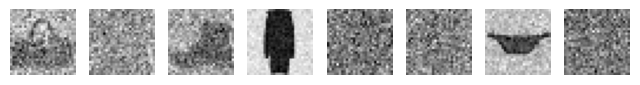

In [24]:
images, _ = next(iter(original_dloader))
print("Original images")
plot_multiple_images(images.permute(0, 2, 3, 1)[:8].detach().cpu().numpy())
plt.show()
noisy_img, steps, noise = create_noisy_image(images, T, alpha_bar)
print("steps:", steps[:8].detach().cpu().numpy())
print("Noisy images")
plot_multiple_images(noisy_img.permute(0, 2, 3, 1)[:8].detach().cpu().numpy())
plt.show()

In [28]:
import numpy as np

embed_size = 32

p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
# p
i

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [26, 26, 26, ..., 26, 26, 26],
       [28, 28, 28, ..., 28, 28, 28],
       [30, 30, 30, ..., 30, 30, 30]])

In [29]:
class TimeEncoding(nn.Module):
    def __init__(self, T, embed_size, dtype=torch.float32):
        super().__init__()
        assert embed_size % 2 == 0, "embed_size must be even"

        p = torch.arange(T + 1).unsqueeze(1)
        i = torch.arange(0, embed_size, 2)
        t_emb = torch.zeros((T + 1, embed_size), dtype=dtype)
        t_emb[:, ::2] = torch.sin(p / 10_000 ** (i / embed_size))
        t_emb[:, 1::2] = torch.cos(p / 10_000 ** (i / embed_size))

        self.register_buffer('time_encodings', t_emb)

    def forward(self, inputs):
        return self.time_encodings[inputs]

time_embed = TimeEncoding(1000, 64)
time_embed([3, 12, 42]).size()

torch.Size([3, 64])

In [43]:
class DiffusionModel(nn.Module):
    def __init__(self, T, embed_size):
        super().__init__()
        self.time_enc = TimeEncoding(T, embed_size)

        self.dim = 16

        self.conv1 = nn.Sequential(
            nn.ZeroPad2d(3),
            nn.Conv2d(1, self.dim, 3),
            nn.BatchNorm2d(self.dim),
            nn.ReLU()
        )
        self.adapt_time_enc = nn.Linear(embed_size, self.dim)

    def forward(self, X_noisy, time_input):

        time_enc = self.time_enc(time_input)
        Z = self.conv1(X_noisy)
        time = self.adapt_time_enc(time_enc)
        Z = Z + time.unsqueeze(2).unsqueeze(3)

        return Z


model = DiffusionModel(1000, 64)
# X_noisy, step, _ = next(iter(train_dloader))
X_noisy = torch.randn(32, 1, 28, 28)
step = torch.randint(0, 1001, size=(32,))
model(X_noisy.float(), step).size()

torch.Size([32, 16, 32, 32])

In [31]:
model = nn.ZeroPad2d(3)
model(torch.randn(32, 1, 3, 3))

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.8287,  0.5592,  1.3543,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000, -1.1532, -0.0017,  1.4374,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000, -1.2421, -0.2287,  1.3168,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000]]]])